# 1.Frame the problem

this is a classification problem and we got original data which contains 5 features and 3 labels, each pixel can regarded as a sample

# 2.Input the data

In [1]:
#all packages which will be used
import numpy as np
import pandas as pd
from scipy.io import loadmat
import time
import random

#plot
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold


#scipy
from scipy.stats import chisquare
from scipy.stats import chi2
from scipy.spatial import distance


#math
from math import log

In [140]:
#data=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\dataset.mat")
dataset=loadmat("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\dataset.mat",mat_dtype=True)

In [141]:
data=dataset["dataset"]
type(data)

numpy.ndarray

then we try to plot one image to see what it looks like

In [142]:
data[12][0][0][0][3].shape
#for element in data[12][0][0][0][1][:,:,20].flat:
    #assert element == 0

(320, 320, 43)

In [143]:
for i in range(len(data)):
    print(data[i][0][0][0][0][:,:,3,1].shape)
    
len(data)

(34, 41)
(80, 82)
(82, 74)
(89, 102)
(66, 78)
(69, 83)
(50, 57)
(55, 69)
(64, 65)
(99, 83)
(107, 99)
(320, 320)
(320, 320)
(320, 320)


14

In [144]:
data2=data[1][0][0][0][0][:,:,8,0] #[:,:,slices,features]

In [145]:
def plot_image(data,stuck,slices,features):
    target_data=data[stuck][0][0][0][0][:,:,slices,features]
    target_image=target_data.reshape(target_data.shape[0],target_data.shape[1])
    plt.imshow(target_image,cmap = matplotlib.cm.binary)
    plt.axis("off") #close the axis number
    plt.show()


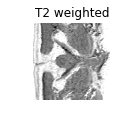

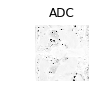

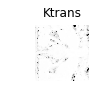

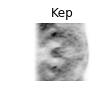

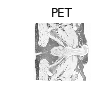

In [146]:
stuck,slices,features=11,10,0
plt.figure(figsize=(8,4))

plt.subplot(151)
plt.title("T2 weighted")
plot_image(data,stuck,slices,features)

plt.subplot(152)
plt.title("ADC")
plot_image(data,stuck,slices,features+1)

plt.subplot(153)
plt.title("Ktrans")
plot_image(data,stuck,slices,features+2)

plt.subplot(154)
plt.title("Kep")
plot_image(data,stuck,slices,features+3)

plt.subplot(155)
plt.title("PET")
plot_image(data,stuck,slices,features+4)

then we try to find out the labels distribution

In [147]:
labelA=data[3][0][0][0][1]
labelA.shape

(89, 102, 85)

In [148]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap',['black','red','blue'],256)
def plot_all(data,stuck,index,slices,features):
    target_data=data[stuck][0][0][0][0][:,:,slices,features]
    target_image1=target_data.reshape(target_data.shape[0],target_data.shape[1])
    target_label=data[stuck][0][0][0][index][:,:,slices]
    target_image2=target_label.reshape(target_label.shape[0],target_label.shape[1])
    plt.imshow(target_image1,cmap = matplotlib.cm.binary,alpha=0.8)
    plt.imshow(target_image2,cmap = cmap1,interpolation="bilinear",alpha=0.2)
    plt.axis("off") #close the axis number
    plt.show()



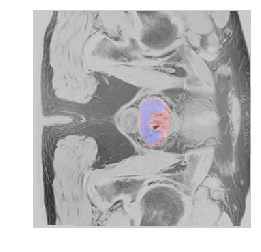

In [149]:
stuck,slices,index,features=13,20,1,4
#plot_image(data,stuck,slices,0)
#plot_label(data,stuck,2,slices)
plot_all(data,stuck,index,slices,features)

# 3. Exploring the features

## 3.1 Extract prostate region

we can find that 1-11 strucks are expected by experts and 12-14 are histological analysis because it is more reliable than the experts,and later 1-11 strucks will be out training set and 12-14 will be out validation set

In [150]:

experts_num,histo_num=11,3
label_final=[]
for i in range(experts_num):
    labelA=data[i][0][0][0][1]
    labelB=data[i][0][0][0][2]
    for index,(item_A,item_B) in enumerate(zip(labelA.flat,labelB.flat)):
                if item_A == item_B:
                    pass
                else:
                    labelA.flat[index]=0
    label_final.append(labelA)


then append the histological struck

In [151]:
for j in range(histo_num):
    labelC=data[j+11][0][0][0][3]
    label_final.append(labelC)

label=np.array(label_final)
label.shape

(14,)

then our task divided into two parts:
- isolate the feature vector of prostate tissure from the whole set
- try to transfer first feature TR wighted MR images

then let us create train data set and validation set respectively

In [152]:
train_data=data[:experts_num]
train_label=label[:experts_num]
val_data=data[:-experts_num]
val_label=label[:-experts_num]
val_label.shape

(3,)

In [154]:
train_isolated_feature=[]
train_isolated_label=[]
val_isolated_feature=[]
val_isolated_label=[]
def isolate_feature(data,label,isolated_feature,isolated_label):
    for i in range(len(data)):
        image=data[i][0][0][0][0]
        target_image=image.reshape(image.shape[0]*image.shape[1]*image.shape[2],image.shape[3])
        target_label=label[i].reshape(-1,1)
        for index,item in enumerate(target_label):
            if item == 0 :
                pass
            else:
                isolated_label.append(item)
                isolated_feature.append(target_image[index])
    return isolated_feature,isolated_label
        

isolate_feature(train_data,train_label,train_isolated_feature,train_isolated_label)
isolate_feature(val_data,val_label,val_isolated_feature,val_isolated_label)

print(len(train_isolated_feature))

355455


In [155]:
train_isolated_feature=pd.DataFrame(np.array(train_isolated_feature))
train_isolated_label=pd.DataFrame(np.array(train_isolated_label))
val_isolated_feature=pd.DataFrame(np.array(val_isolated_feature))
val_isolated_label=pd.DataFrame(np.array(val_isolated_label))
train_isolated_feature.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_feature.csv",index=False)
train_isolated_label.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_label.csv",index=False)
val_isolated_feature.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_feature.csv",index=False)
val_isolated_label.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_label.csv",index=False)
len(train_isolated_feature)

355455

it means that prostate area has 355455 voxels

In [156]:
sum_d=0
for i in range(11):
    temp_data=data[i][0][0][0][0]
    temp_d=temp_data.reshape(temp_data.shape[0]*temp_data.shape[1]*temp_data.shape[2],temp_data.shape[3])
    sum_d +=temp_d.shape[0]
    
sum_d

4696937

total voxel is 4696937

## 3.2 Normalization & Outliers detection

so we see we isolated the 355455 prostate features from the 4696937 the whole train set

then try to construct the whole pipeline of the features enginerring
- Transform the first feature TR wighted
- normalize all the features
- Outlier detection and removal

In [27]:
#read data
X_train=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_feature.csv")
y_train=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_label.csv")
X_val=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_feature.csv")
y_val=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\val_label.csv")

In [28]:
scaler1=MinMaxScaler(feature_range=(0, 1), copy=True)
class Feature_scaling(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        scaler1.fit(X['0'])
        return self
    def transform(self,X,y=None):
        X['0']=scaler1.transform(X['0'])
        return X

In [29]:
scaler2=StandardScaler()
class Normalization(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        scaler2.fit(X[["1","2","3","4"]])
        return self
    def transform(self,X,y=None):
        X[["1","2","3","4"]]=scaler2.transform(X[["1","2","3","4"]])
        return pd.DataFrame(X)

In [30]:
feature_eng=Pipeline([("feature_scale",Feature_scaling()),
                     ("normalization",Normalization())])

In [31]:
#build a dataset to test our pipeline
np.random.seed(42)
test=pd.DataFrame(10*np.random.rand(10,5),columns=['0','1','2','3','4'])
test

,0,1,2,3,4
0,3.745401,9.507143,7.319939,5.986585,1.560186
1,1.559945,0.580836,8.661761,6.011150,7.080726
2,0.205845,9.699099,8.324426,2.123391,1.818250
3,1.834045,3.042422,5.247564,4.319450,2.912291
4,6.118529,1.394939,2.921446,3.663618,4.560700
5,7.851760,1.996738,5.142344,5.924146,0.464504
6,6.075449,1.705241,0.650516,9.488855,9.656320
7,8.083973,3.046138,0.976721,6.842330,4.401525
8,1.220382,4.951769,0.343885,9.093204,2.587800
9,6.625223,3.117111,5.200680,5.467103,1.848545


In [32]:
feature_eng.fit_transform(test)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,0,1,2,3,4
0,0.449289,1.827646,0.955786,0.044140,-0.793325
1,0.171881,-1.084032,1.407208,0.055602,1.263881
2,0.000000,1.890260,1.293720,-1.758378,-0.697159
3,0.206673,-0.281085,0.258588,-0.733724,-0.289469
4,0.750519,-0.818479,-0.523975,-1.039727,0.324804
5,0.970524,-0.622178,0.223189,0.015007,-1.201627
6,0.745050,-0.717261,-1.287972,1.678256,2.223666
7,1.000000,-0.279874,-1.178229,0.443420,0.265488
8,0.128779,0.341726,-1.391130,1.493650,-0.410389
9,0.814835,-0.256723,0.242815,-0.198244,-0.685870


now, we try to apply the outliers detection first try the chi-square distribution$$\chi^2=\sum\frac{(A-E)^2}{E}$$

In [33]:
MD1=np.array([1.01,0.70,0.30,0.38,1.15,
            2.64,1.71,0.71,0.86,0.80,0.69,0.87,
            0.68,1.72,1.76,2.37,1.22,0.20,
            1.86,2.27,0.83,0.42,0.26,1.05,
            2.91,1.59,1.58,0.40])
#the second column in the Table in article[13]
MD2=np.array([2.25,2.32,1.59,1.27,0.30,0.77,
             1.85,1.85,1.36,1.75,1.47,1.84,
             1.48,1.78,1.69,1.29,2.70,1.50,
             1.59,0.81,2.18])
chi2.fit(MD1,2)
np.sqrt(chi2.ppf(0.975,2)) 

2.7162030314812387

the result is 2.7162030314812387 and the result in the article is 2.72 , they are almost the same

**there are two ways to approxiamte the MVE(minimum volume elliposid estimator)**
- the resampling algorithm
- the projection algorithm

we can wirte three approxiamtion respectively,first calculate **mahalanbios distance** $$MD_i=\sqrt{(x_i-\mu)C^{-1}(x_i-\mu)^T}$$
and after we get chi value of $MD$ we have can calculate $RD$(Robust distances) in the same equation but different approximation

In [112]:
#direct algorithm(with out robust estimation)
#calculate the mahalanbios distance
#create a normal distribution dataset temp1 to test the code
np.random.seed(42)
temp1=np.random.randn(100,5)*10
temp1=pd.DataFrame(temp1)
temp2=pd.DataFrame(np.ones((100,1)))

In [35]:
def mahalanbios_dis(temp1):
    return distance.cdist(temp1,np.array([temp1.mean()]),metric='mahalanobis',VI=np.mat(temp1.cov()).I).ravel()

mahalanbios_dis(temp1)

array([ 1.8536603 ,  2.54078351,  2.39429827,  1.59169233,  1.52522535,
        2.05031997,  2.48515786,  1.63665246,  2.82495958,  1.31362208,
        3.0252397 ,  2.70292567,  1.71711131,  3.06786033,  2.1184159 ,
        2.15113515,  2.17362195,  1.65062406,  1.8302518 ,  1.90459567,
        2.35492955,  1.9267237 ,  2.46415937,  2.20356385,  2.37303588,
        2.31809902,  2.45334865,  2.07161002,  1.97151051,  2.23707159,
        2.54397187,  1.84695113,  1.40510532,  2.49519601,  2.18510305,
        2.46068057,  2.8816689 ,  1.32722041,  2.15227572,  2.24978527,
        2.06619763,  3.05245276,  1.7513338 ,  1.88443533,  1.63769579,
        2.22963467,  1.34995478,  2.04428807,  2.9765669 ,  3.16287086,
        1.81878474,  1.88581019,  2.69588974,  1.47621447,  2.56178087,
        1.6868405 ,  2.25401537,  1.85019763,  3.00966301,  1.82060704,
        1.75860827,  1.93031817,  2.62980786,  1.8777912 ,  2.31902861,
        1.17985495,  2.75255764,  2.15344797,  1.19826792,  1.91

In [36]:
MD=[]
for i in range(len(temp1)):
    md_dis=float(distance.mahalanobis(temp1.iloc[i],np.array([temp1.mean()]),np.mat(temp1.cov().as_matrix()).I))
    MD.append(md_dis)

np.array(MD)

array([ 1.8536603 ,  2.54078351,  2.39429827,  1.59169233,  1.52522535,
        2.05031997,  2.48515786,  1.63665246,  2.82495958,  1.31362208,
        3.0252397 ,  2.70292567,  1.71711131,  3.06786033,  2.1184159 ,
        2.15113515,  2.17362195,  1.65062406,  1.8302518 ,  1.90459567,
        2.35492955,  1.9267237 ,  2.46415937,  2.20356385,  2.37303588,
        2.31809902,  2.45334865,  2.07161002,  1.97151051,  2.23707159,
        2.54397187,  1.84695113,  1.40510532,  2.49519601,  2.18510305,
        2.46068057,  2.8816689 ,  1.32722041,  2.15227572,  2.24978527,
        2.06619763,  3.05245276,  1.7513338 ,  1.88443533,  1.63769579,
        2.22963467,  1.34995478,  2.04428807,  2.9765669 ,  3.16287086,
        1.81878474,  1.88581019,  2.69588974,  1.47621447,  2.56178087,
        1.6868405 ,  2.25401537,  1.85019763,  3.00966301,  1.82060704,
        1.75860827,  1.93031817,  2.62980786,  1.8777912 ,  2.31902861,
        1.17985495,  2.75255764,  2.15344797,  1.19826792,  1.91

In [181]:
class outliers_clean_direct(BaseEstimator,TransformerMixin):
    def __init__(self,p_free,labels,md_dis=pd.Series([]),p_value=0.):
        self.md_dis=md_dis
        self.p_value=p_value
        self.p_free=p_free
        self.labels=labels
    def fit(self,X,y=None):
        mean_value=np.array([X.mean()])
        covar_value=np.mat(X.cov().as_matrix()).I
        print("MD Start")
        self.md_dis=distance.cdist(X,mean_value,metric='mahalanobis',VI=covar_value).ravel()
        print("MD end")
        chi2.fit(self.md_dis,self.p_free)
        self.p_value=np.sqrt(chi2.ppf(0.975,self.p_free))
        return self
    def transform(self,X,y=None): #should be changed to y_train
        count,count1,count2=0,0,0
        count1=X.shape[0]
        print("mahalanbios distance: ",self.md_dis)
        print("cutoff value: ",self.p_value)
        print("Drop Start")
        self.md_dis=pd.DataFrame(self.md_dis,columns=['maha_dis'])
        X=pd.concat([X,self.md_dis],axis=1)
        self.labels=pd.concat([self.labels,self.md_dis],axis=1)
        X=X[X['maha_dis']<=self.p_value]
        self.labels=self.labels[self.labels['maha_dis']<=self.p_value]
        X=pd.DataFrame.reset_index(X).drop('index',axis=1)
        self.labels=pd.DataFrame.reset_index(self.labels).drop('index',axis=1)
        count2=X.shape[0]
        count=count1-count2
        print("Drop End")
        print("drop count:",count)
        return X,self.labels,self.md_dis
                

In [269]:
def plot_outliers(maha_dis,cdf1,cdf2,cdf3):
    x=range(len(maha_dis))
    plt.figure(figsize=(16,12))
    plt.scatter( x, maha_dis )

    plt.hlines( np.sqrt(chi2.ppf(cdf1, 5)), 0, len(maha_dis), label ="%5f $\chi^2$ quantile"%(cdf1), linestyles = "solid" ) 
    plt.hlines( np.sqrt(chi2.ppf(cdf2, 5)), 0, len(maha_dis), label ="%5f $\chi^2$ quantile"%(cdf2), linestyles="dashed" ) 
    plt.hlines( np.sqrt(chi2.ppf(cdf3, 5)), 0, len(maha_dis), label ="%5f $\chi^2$ quantile"%(cdf3), linestyles = "dotted" )

    plt.legend()
    plt.ylabel("recorded value",fontsize=20)
    plt.xlabel("observation",fontsize=20)
    plt.title( 'Detection of outliers at different $\chi^2$ quantiles',fontsize=25 )

    plt.show()

In [270]:
#sample test
sample,labelset,maha_dis,count=outliers_clean_direct(p_free=5,labels=temp2).fit_transform(temp1)

MD Start
MD end
0
mahalanbios distance:  [ 1.80735022  1.86254961  2.872682    2.29450181  2.2390532   1.59138781
  2.37295093  2.79690286  1.59026438  2.41650676  1.46907549  1.77813959
  1.98639564  1.96365989  3.31187249  1.99171148  1.95832329  1.31774636
  1.34776911  1.71213115  2.05568064  2.01467137  3.13572134  1.82485625
  2.62819218  2.63798932  2.16675694  2.26821553  2.23285737  2.0381425
  0.89838039  2.47782806  2.18326474  2.30075561  1.46283758  3.22362399
  1.52960256  1.89878039  1.74931974  1.45466784  2.09675996  3.7054333
  1.76311086  1.29792269  3.53076835  2.03537779  2.2815249   2.54599507
  1.80720101  1.94389537  3.28376942  1.63353109  3.54775133  2.54641973
  2.60507386  0.86830014  3.01026638  2.51168875  1.14232669  1.33970177
  1.6159812   1.52461077  1.87884294  0.74474362  2.4695653   1.86782565
  1.65057969  1.11566737  1.32582489  2.09906596  1.75792667  1.40916682
  1.90637382  0.8685709   2.67719557  2.48694991  2.49399796  2.25979378
  2.55552617

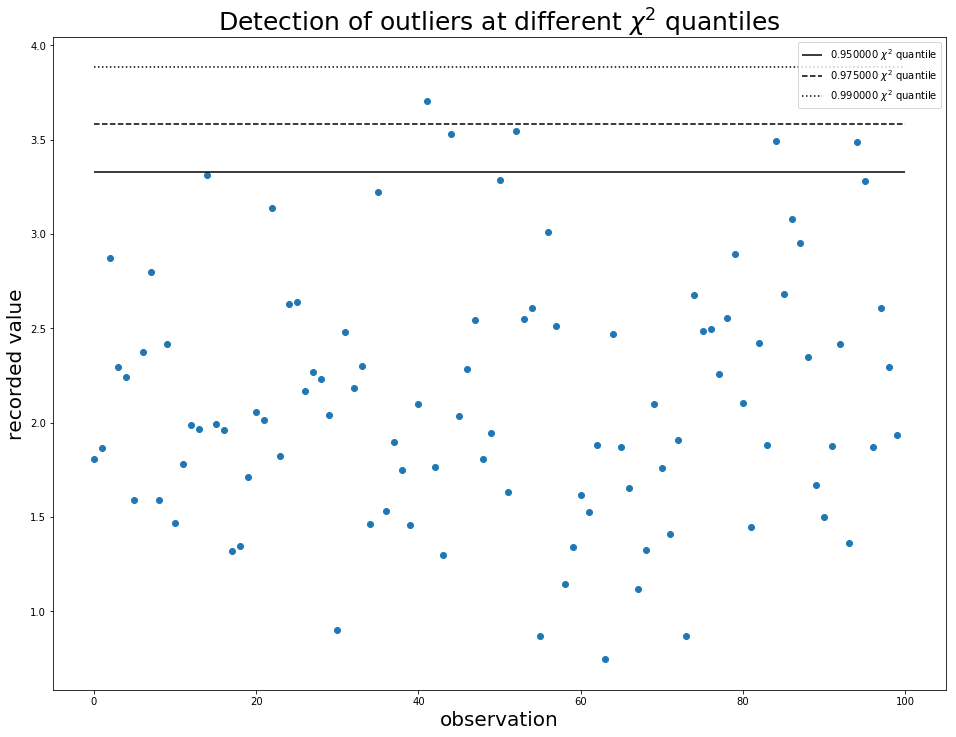

In [271]:
plot_outliers(maha_dis,0.95,0.975,0.99) #here recorded value is mahalanobis distance

Then we try to split the whole the dataset into 1000 subsets

In [187]:
X_train_scaled=feature_eng.fit_transform(X_train)
X_train_new,y_train_new,maha_dis=outliers_clean_direct(p_free=5,labels=y_train.copy()).fit_transform(X_train_scaled)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


MD Start
MD end
0
mahalanbios distance:  [ 3.3379388   3.37713725  3.03612973 ...,  1.8644143   1.26067642
  2.14461159]
cutoff value:  3.58224817594
Drop Start
Drop End
drop count: 23139


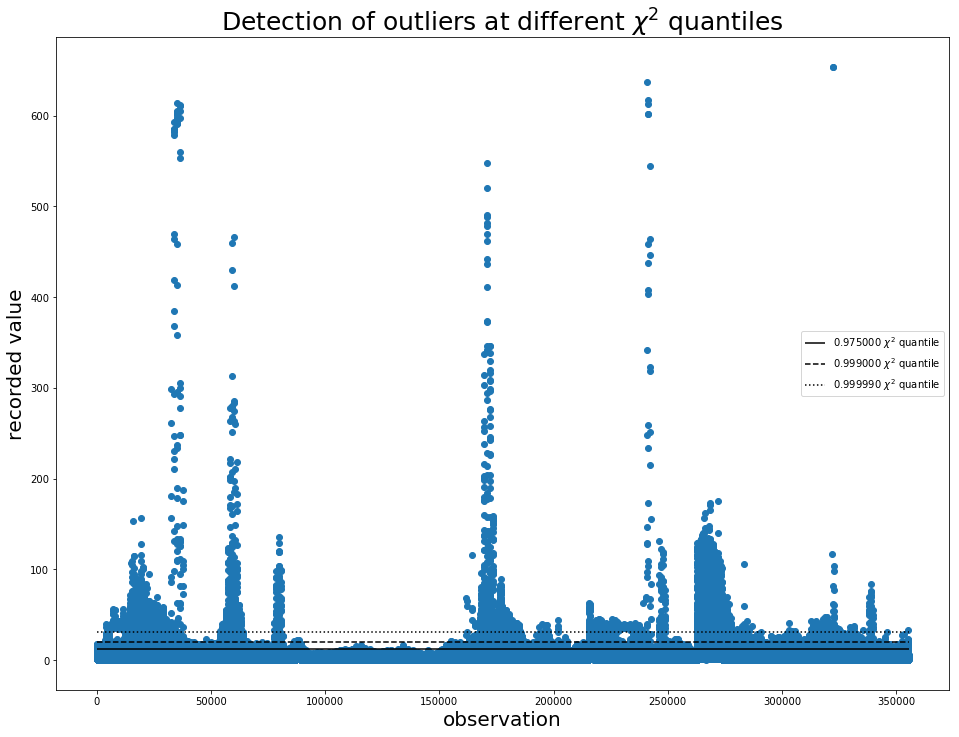

In [103]:
plot_outliers(maha_dis,0.975,0.999,0.99999)

in the first approach , there are 23139 outliers has been droped, then we implement robust algorithm and see

In [201]:
#resampling algorithm
p_distr=0.975
n_subsamples=np.ceil(log((1-p_distr),1-(0.5)**6)).astype(int)
n_subsamples

235

because the number of the subsample set $m$ satisfy $$1-(1-(1-0.5)^{p+1})^m\geq p_{distribution}$$ but this is a large number of groups and it will take a long time to calculate. Due to the paper we know the statistic order of the subset distance $m^2_{k+1}$ satisfly $$m^2_{k+1}\leq(\frac{V_k}{det(C_{k+1})})^{1/p}=M$$ so if $m^2_{k+1}$ exceed, then stop

In [261]:

class outliers_clean_resampling(BaseEstimator,TransformerMixin):
    def __init__(self,p_free,labels,md_dis=pd.Series([]),p_value_1=0.,p_value_2=0.,h_value=0):
        self.md_dis=md_dis
        self.p_value_1=p_value_1
        self.p_value_2=p_value_2
        self.p_free=p_free
        self.h_value=h_value
        self.labels=labels
    def fit(self,X,y=None):
        self.h_value=np.int((X.shape[0]+self.p_free+1)/2)
        mean_value=np.array([X.mean()])
        cov_value=np.mat(X.cov().as_matrix()).I
        print("MD Start")
        self.md_dis=distance.cdist(X,mean_value,metric='mahalanobis',VI=cov_value).ravel()
        print("MD end")
        chi2.fit(self.md_dis,self.p_free)
        self.p_value_1=np.sqrt(chi2.ppf(0.975,self.p_free))
        self.p_value_2=np.sqrt(chi2.ppf(0.5,self.p_free))
        return self
    def transform(self,X,y=None):
        np.random.seed(30)
        mean_set,cov_set,m_dis_order,V_j=[],[],[],[]
        print("Resampling begin")
        start1=time.time()
        for subset in range(n_subsamples):
            if subset%50==0:
                print("replications number:%d time:%5.1f minute"%(subset,(time.time()-start1)/60))
            sample_ID=[]
            for index in range(self.p_free+1):
                sample_ID.append(np.random.choice(range(len(X)),replace=False))
            X_tr=np.array(X.iloc[sample_ID])
            sub_mean=np.array([(1/(self.p_free+1))*np.sum(X_tr,axis=0)])
            mean_set.append(sub_mean)
            sub_cov=np.mat((1/(self.p_free))*np.dot((X_tr-sub_mean).T,(X_tr-sub_mean))).I
            cov_set.append(sub_cov)
            m_dis=pd.Series((distance.cdist(X,sub_mean,metric='mahalanobis',VI=sub_cov)**2).ravel())\
            .sort_values(ascending=True).iloc[self.h_value] #ascending=True : from small to big
            #if subset != 0 :
                #if m_dis>=(V_j[subset-1]/sub_cov.I.det())**(1/self.p_free):
                    #break
                #else:
                    #pass
            m_dis_order.append(m_dis)
            V_j.append(m_dis*np.linalg.det(sub_cov))
        print("Resampling end")
        #print(m_dis_order[])
        J_index=pd.Series(V_j).sort_values(ascending=True).index.tolist()[0]
        m_dis_value=m_dis_order[J_index]
        robust_mean=mean_set[J_index]
        robust_cov=((1+15/(X.shape[0]-self.p_free))**2)*(1/self.p_value_2)*m_dis_value*cov_set[J_index]
        print("RD Start")
        robust_dis=distance.cdist(X,robust_mean,metric='mahalanobis',VI=robust_cov).ravel()
        print("RD end")
        print("Robust distance: ",robust_dis)
        print("Cutoff value: ",self.p_value_1)
        count,count1,count2=0,0,0
        count1=X.shape[0]
        print("Drop Start")
        robust_dis=pd.DataFrame(robust_dis,columns=['robust_dis'])
        X=pd.concat([X,robust_dis],axis=1)
        self.labels=pd.concat([self.labels,robust_dis],axis=1)
        X=X[X['robust_dis']<=self.p_value_1].copy()
        self.labels=self.labels[self.labels['robust_dis']<=self.p_value_1].copy()
        X=pd.DataFrame.reset_index(X).drop('index',axis=1)
        self.labels=pd.DataFrame.reset_index(self.labels).drop('index',axis=1)
        count2=X.shape[0]
        count=count1-count2
        print("Drop End")
        print("drop count:",count)
        return X,self.labels,robust_dis

In [273]:
#use test temp set for testing
sample,labelset,robust_dis=outliers_clean_resampling(p_free=5,labels=temp2).fit_transform(temp1)

MD Start
MD end
Resampling begin
replications number:0 time:  0.0 minute
replications number:50 time:  0.0 minute
replications number:100 time:  0.0 minute
replications number:150 time:  0.0 minute
replications number:200 time:  0.0 minute
replications number:250 time:  0.0 minute
Resampling end
RD Start
RD end
Robust distance:  [  1.12497266e+16   4.34368836e+16   2.88415780e+16   1.63201632e+16
   2.73450005e+16   8.81269053e+15   4.25962678e+16   2.26923447e+15
   9.73649053e+15   3.76334970e+16   3.91100784e+16   5.09510621e+16
   1.27138370e+16   1.40065272e+16   1.57852446e+16   1.65957052e+16
   4.69438286e+16   3.13931026e+16   2.07133329e+08   4.45270569e+16
   2.48906171e+16   1.90248060e+16   3.04781585e+16   4.53529966e+16
              nan   7.95400081e+16   1.65545099e+16   5.65408743e+16
   2.35699457e+16   7.17801193e+16   1.99401560e+16   5.73465861e+16
   5.74861851e+16   4.52459495e+16   1.96749001e+15   4.75882527e+15
   5.40586655e+16   3.12675525e+08   3.32443356e

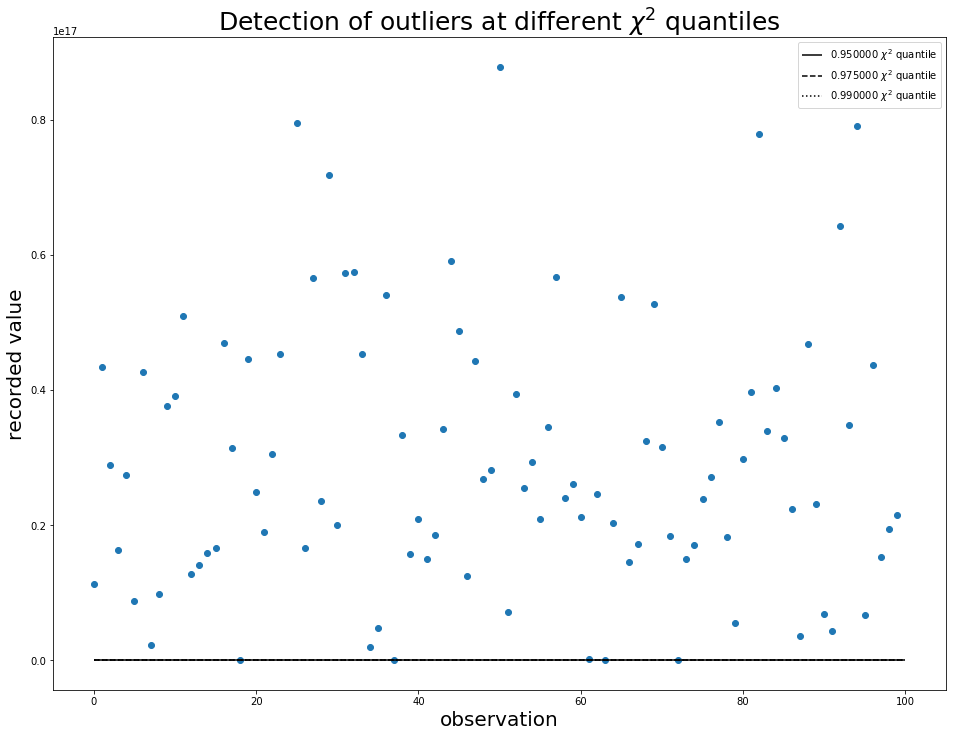

In [274]:
plot_outliers(robust_dis,0.95,0.975,0.99)

In [275]:
n_subsamples=253
X_train_scaled=feature_eng.fit_transform(X_train)
X_train_new,y_train_new,robust_dis=outliers_clean_resampling(p_free=5,labels=y_train).fit_transform(X_train_scaled)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


MD Start
MD end
Resampling begin
replications number:0 time:  0.0 minute
replications number:50 time:  0.6 minute
replications number:100 time:  1.3 minute
replications number:150 time:  1.9 minute
replications number:200 time:  2.6 minute
replications number:250 time:  3.2 minute
Resampling end
RD Start
RD end
Robust distance:  [ 6.90672993  7.42642383  5.88375227 ...,  4.07629182  3.38806106
  5.5977355 ]
Cutoff value:  3.58224817594
Drop Start
Drop End
drop count: 179995


In [229]:
n_subsamples=3000
X_train_scaled=feature_eng.fit_transform(X_train)
X_train_new,y_train_new,robust_dis=outliers_clean_resampling(p_free=5,labels=y_train).fit_transform(X_train_scaled)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


MD Start
MD end
Resampling begin
replications number:0 time:  0.0 minute
replications number:50 time:  0.6 minute
replications number:100 time:  1.2 minute
replications number:150 time:  1.8 minute
replications number:200 time:  2.4 minute
replications number:250 time:  3.0 minute
replications number:300 time:  3.6 minute
replications number:350 time:  4.2 minute
replications number:400 time:  4.8 minute
replications number:450 time:  5.4 minute
replications number:500 time:  6.0 minute
replications number:550 time:  6.6 minute
replications number:600 time:  7.2 minute
replications number:650 time:  7.8 minute
replications number:700 time:  8.4 minute
replications number:750 time:  9.0 minute
replications number:800 time:  9.6 minute
replications number:850 time: 10.2 minute
replications number:900 time: 10.8 minute
replications number:950 time: 11.4 minute
replications number:1000 time: 12.0 minute
replications number:1050 time: 12.6 minute
replications number:1100 time: 13.2 minute
r

In [109]:
#CAUTION!! don't overwirte this again
robust_dis=pd.Series(robust_dis)
robust_dis.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\mahalanobis_distance.csv",index=False)

In [110]:
robust_dis=pd.read_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\mahalanobis_distance.csv")
robust_dis=np.array(maha_dis)

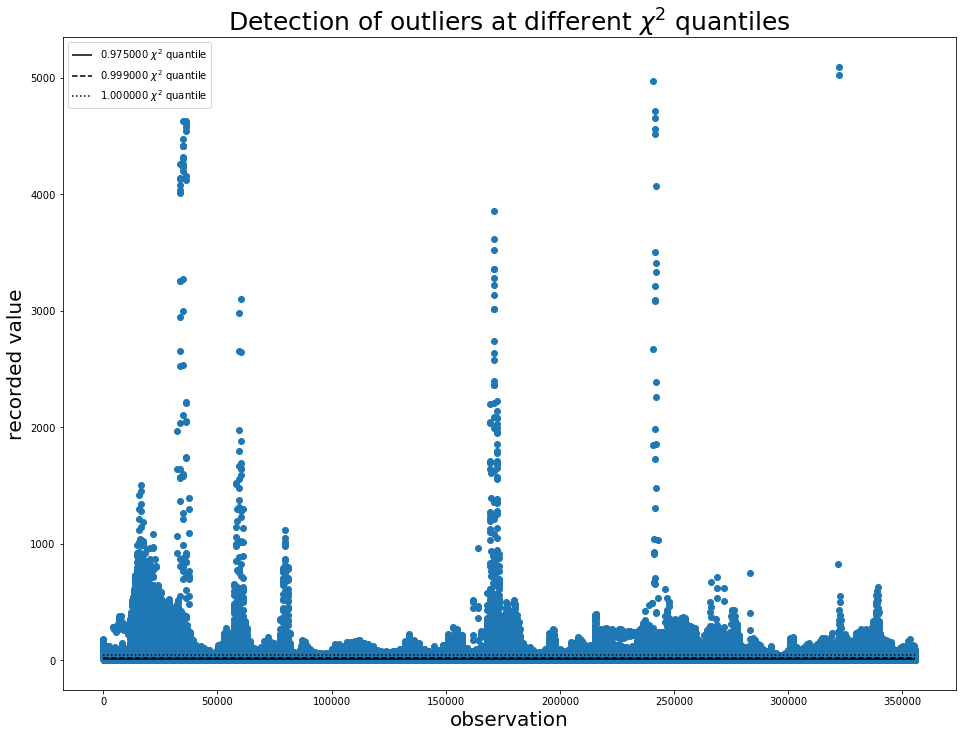

In [231]:
plot_outliers(robust_dis,0.975,0.999,0.9999999) #with n_subsamples=3000

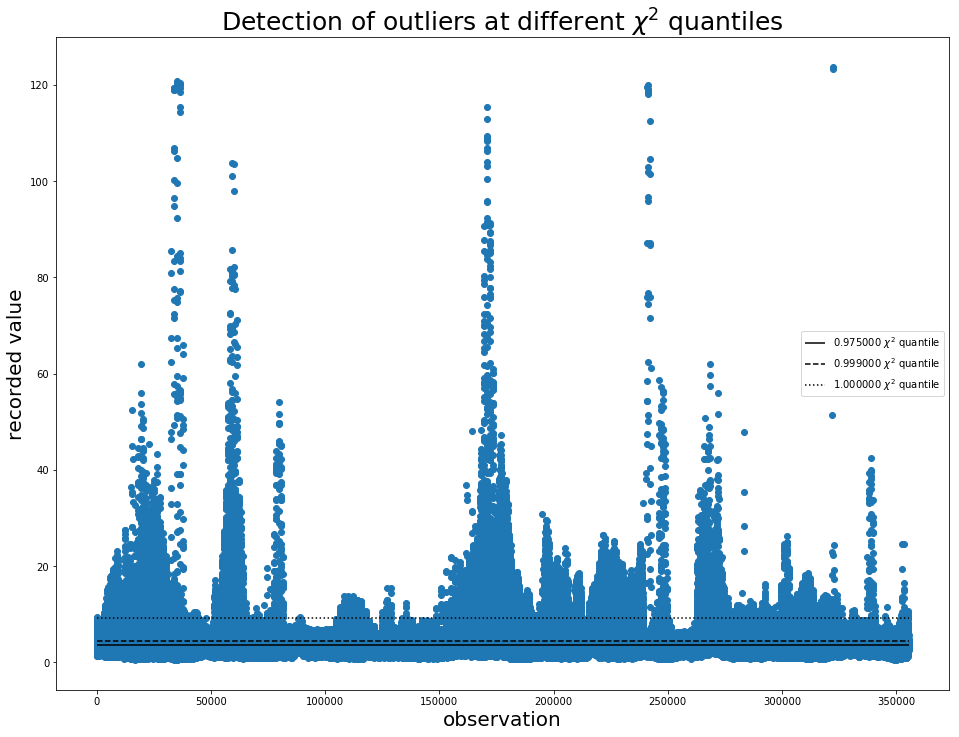

In [279]:
plot_outliers(robust_dis,0.975,0.999,0.9999999999999999) #with n_subsamples=253

**Tuning conclusion** :from the plot 1 and plot 2 we can figure out n_subsample or replications better remain low value

In [202]:
count

95037

In [203]:
X_train_new.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_resampling_X.csv",index=False)
y_train_new.to_csv("C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\medData\\train_resampling_y.csv",index=False)

In [134]:
#the projection algorithm

In [131]:
1/4

0.25